# 1 Problem Statement

Given the data collected at the time of application, we need to predict the loan outcome.

# 2 Dataset Description
Both train and test sets contain three files - accounts_data_train.json, enquiry_data_train.json, train_flag.csv.

# 3 Data Preprocessing

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, log_loss, roc_auc_score

sns.set_style('whitegrid')
os.chdir('E:/new_download/senior_ds_test/data')

## 3.1 Converting the provided files to proper json format
with open('train/accounts_data_train.json') as file:
    txt = file.read()
txt = txt[3:-3].replace('"','').replace('[','').replace(']','')
records = txt.split('}, {')
dct = {'credit_type':[],'loan_amount':[],'amount_overdue':[],'open_date':[],'closed_date':[],'payment_hist_string':[],'uid':[]}
for record in records:
    lst = record.split(', ')
    for elem in lst:
        key, value = elem.split(': ')
        if key=='loan_amount':value=float(value)
        elif key=='amount_overdue':value=float(value)
        #elif key=='open_date':value=datetime.strptime(value,'%Y-%m-%d')
        elif key=='closed_date':
            if value=='NaN':value=np.nan
            #else:value=datetime.strptime(value,'%Y-%m-%d')
        dct[key].append(value)
accounts_data = pd.DataFrame(dct)
accounts_data.to_json('new_train/accounts_data_train.json',orient="records")

with open('train/enquiry_data_train.json') as file:
    txt = file.read()
txt = txt[3:-3].replace('"','').replace('[','').replace(']','')
records = txt.split('}, {')
dct = {'enquiry_type':[],'enquiry_amt':[],'enquiry_date':[],'uid':[]}
for record in records:
    lst = record.split(', ')
    for elem in lst:
        key, value = elem.split(': ')
        if key=='enquiry_amt':value=float(value)
        #elif key=='enquiry_date':value=datetime.strptime(value,'%Y-%m-%d')
        dct[key].append(value)
enquiry_data = pd.DataFrame(dct)
enquiry_data.to_json('new_train/enquiry_data_train.json',orient="records")

with open('test/accounts_data_test.json') as file:
    txt = file.read()
txt = txt[3:-3].replace('"','').replace('[','').replace(']','')
records = txt.split('}, {')
dct = {'credit_type':[],'loan_amount':[],'amount_overdue':[],'open_date':[],'closed_date':[],'payment_hist_string':[],'uid':[]}
for record in records:
    lst = record.split(', ')
    for elem in lst:
        key, value = elem.split(': ')
        if key=='loan_amount':value=float(value)
        elif key=='amount_overdue':value=float(value)
        #elif key=='open_date':value=datetime.strptime(value,'%Y-%m-%d')
        elif key=='closed_date':
            if value=='NaN':value=np.nan
            #else:value=datetime.strptime(value,'%Y-%m-%d')
        dct[key].append(value)
accounts_data = pd.DataFrame(dct)
accounts_data.to_json('new_test/accounts_data_test.json',orient="records")

with open('test/enquiry_data_test.json') as file:
    txt = file.read()
txt = txt[3:-3].replace('"','').replace('[','').replace(']','')
records = txt.split('}, {')
dct = {'enquiry_type':[],'enquiry_amt':[],'enquiry_date':[],'uid':[]}
for record in records:
    lst = record.split(', ')
    for elem in lst:
        key, value = elem.split(': ')
        if key=='enquiry_amt':value=float(value)
        #elif key=='enquiry_date':value=datetime.strptime(value,'%Y-%m-%d')
        dct[key].append(value)
enquiry_data = pd.DataFrame(dct)
enquiry_data.to_json('new_test/enquiry_data_test.json',orient="records")

## 3.2 Loading the data

In [2]:
# if there is time component in the data, it is better to sort by time and do time based split
# so that we can see if our model is working better on the future data
accounts_data_train = pd.read_json('new_train/accounts_data_train.json').sort_values('open_date')
enquiry_data_train = pd.read_json('new_train/enquiry_data_train.json').sort_values('enquiry_date')
train_flag = pd.read_csv('new_train/train_flag.csv')
accounts_data_train['open_date'] = pd.to_datetime(accounts_data_train['open_date'])
accounts_data_train['closed_date'] = pd.to_datetime(accounts_data_train['closed_date'])
enquiry_data_train['enquiry_date'] = pd.to_datetime(enquiry_data_train['enquiry_date'])

In [3]:
print(accounts_data_train.shape)
print(enquiry_data_train.shape)
print(train_flag.shape)

(1245310, 7)
(1909926, 4)
(261383, 3)


In [4]:
accounts_data_train.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
968935,Consumer credit,92290.5,0.0,2013-01-01,2013-11-04,000000000000000000000000000000,UFS67084307
698933,Consumer credit,29754.0,0.0,2013-01-01,NaT,0000000000000000000000000000000000000000000000...,OPI95979147
698905,Credit card,225000.0,0.0,2013-01-01,NaT,0000000000000000000000000000000000000000000000...,OPI73402522
593284,Consumer credit,135000.0,0.0,2013-01-01,NaT,0000000000000000000000000000000000000000000000...,MKN48457364
284830,Consumer credit,100912.5,0.0,2013-01-01,2014-08-27,0000000000000000000000000000000000000000000000...,FXO29490350


<b>Observation:-</b>The dates could be upto 01/01/2021.

In [5]:
accounts_data_train.describe()

,loan_amount,amount_overdue,open_date,closed_date
count,1.245307e+06,1.245310e+06,1245310,782275
mean,3.523541e+05,4.202288e+01,2017-11-15 01:15:58.772353792,2018-03-16 01:09:08.171933952
min,0.000000e+00,0.000000e+00,2013-01-01 00:00:00,1905-12-13 00:00:00
25%,5.114700e+04,0.000000e+00,2016-06-07 00:00:00,2016-11-22 00:00:00
50%,1.246590e+05,0.000000e+00,2018-04-23 00:00:00,2018-07-17 00:00:00
75%,3.087000e+05,0.000000e+00,2019-09-19 00:00:00,2019-11-01 00:00:00
max,3.960000e+08,3.756681e+06,2021-01-01 00:00:00,2021-01-01 00:00:00
std,1.109812e+06,6.668687e+03,NaN,NaN


In [6]:
accounts_data_train.nunique(axis=0)

credit_type                15
loan_amount            189286
amount_overdue           1266
open_date                2923
closed_date              2913
payment_hist_string     45212
uid                    223918
dtype: int64

In [7]:
enquiry_data_train.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
687427,Cash loans,84000,2015-08-30,JIG70884799
489972,Cash loans,89000,2015-10-12,GQW83282743
378886,Another type of loan,108000,2015-10-19,FED76246588
1860153,Loan for the purchase of equipment,99000,2015-11-02,ZIQ19887348
112195,Cash loans,194000,2015-11-08,BOH75325942


In [8]:
enquiry_data_train.describe()

,enquiry_amt,enquiry_date
count,1.909926e+06,1909926
mean,1.160423e+05,2020-03-03 02:34:49.536035072
min,1.007000e+03,2015-08-30 00:00:00
25%,5.600000e+04,2019-10-20 00:00:00
50%,1.080000e+05,2020-05-14 00:00:00
75%,1.590000e+05,2020-09-24 00:00:00
max,4.999950e+05,2021-01-01 00:00:00
std,8.207031e+04,NaN


In [9]:
enquiry_data_train.nunique(axis=0)

enquiry_type        17
enquiry_amt     151941
enquiry_date      1776
uid             261383
dtype: int64

In [10]:
train_flag.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [11]:
train_flag.describe()

,TARGET
count,261383.000000
mean,0.080560
std,0.272159
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [12]:
train_flag.nunique(axis=0)

uid                   261383
NAME_CONTRACT_TYPE         2
TARGET                     2
dtype: int64

## 3.3 Checking for outliers and null values

In [13]:
# checking for dates that could be outliers
accounts_data_train[accounts_data_train['closed_date']<datetime(1970,1,1)]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
752854,Credit card,225000.0,0.0,2014-08-06,1905-12-13,,PSI76661644


In [14]:
# checking for records where open_date>closed_date which is not possible
accounts_data_train[accounts_data_train['open_date']>accounts_data_train['closed_date']]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
147697,Consumer credit,360000.0,0.0,2013-06-05,2013-03-14,,DBX47652567
752854,Credit card,225000.0,0.0,2014-08-06,1905-12-13,,PSI76661644
941309,Consumer credit,157500.0,0.0,2015-11-22,2015-10-09,,TQK82834352
642848,Mortgage,2250000.0,0.0,2017-03-12,2013-10-18,,NLJ87108009
143642,Consumer credit,450000.0,0.0,2017-05-27,2017-04-14,,CZP89943956
664086,Consumer credit,93564.0,0.0,2017-06-02,2016-12-02,,NWS78995671
1208571,Consumer credit,4500000.0,0.0,2017-09-28,2013-01-22,,ZFW60745418
380416,Consumer credit,711450.0,0.0,2018-03-17,2012-09-03,,HXU23242159
920889,Consumer credit,1350000.0,0.0,2018-07-29,2018-02-04,,TFK88667051
1162654,Consumer credit,2700000.0,0.0,2018-08-13,2015-02-14,,YHB76696641


In [15]:
# checking for null values other than closed_date since it could be null if the loan is running
accounts_data_train[accounts_data_train[['credit_type','loan_amount','amount_overdue','open_date','payment_hist_string','uid']].isnull().any(axis=1)]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901
149202,Another type of loan,NaN,0.0,2021-01-01,NaT,,DCX71532515
613183,Another type of loan,NaN,0.0,2021-01-01,NaT,,MVG95017452


In [16]:
# checking for empty strings in the payment_hist_string column.
# this could be due to - the loan was paid within less than 1 month or
# the loan was taken less than 1 month back
accounts_data_train[accounts_data_train['payment_hist_string']=='']

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
624647,Consumer credit,248423.175,0.0,2013-01-01,2013-01-01,,NBJ84882791
660441,Consumer credit,67500.000,0.0,2013-01-03,2013-01-14,,NUS10152033
660446,Consumer credit,71367.210,0.0,2013-01-03,2013-01-14,,NUS10152033
190001,Consumer credit,45000.000,0.0,2013-01-03,2013-01-31,,DZF19669551
1193335,Consumer credit,90000.000,0.0,2013-01-03,2013-01-04,,YXN97131577
...,...,...,...,...,...,...,...
794315,Consumer credit,747000.000,0.0,2020-12-31,NaT,,QOO60405120
65605,Another type of loan,NaN,0.0,2021-01-01,2020-10-21,,BJV01354901
149202,Another type of loan,NaN,0.0,2021-01-01,NaT,,DCX71532515
686275,Microloan,49500.000,0.0,2021-01-01,NaT,,OIO08447095


In [17]:
# loans that were repaid within 1 month
accounts_data_train[(accounts_data_train['payment_hist_string']=='')&((accounts_data_train['closed_date']-accounts_data_train['open_date'])/np.timedelta64(1, 'D')<31)]

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
624647,Consumer credit,248423.175,0.0,2013-01-01,2013-01-01,,NBJ84882791
660441,Consumer credit,67500.000,0.0,2013-01-03,2013-01-14,,NUS10152033
660446,Consumer credit,71367.210,0.0,2013-01-03,2013-01-14,,NUS10152033
190001,Consumer credit,45000.000,0.0,2013-01-03,2013-01-31,,DZF19669551
1193335,Consumer credit,90000.000,0.0,2013-01-03,2013-01-04,,YXN97131577
...,...,...,...,...,...,...,...
484285,Consumer credit,9000.000,0.0,2020-12-28,2020-12-30,,KBX30473139
1022809,Microloan,27000.000,0.0,2020-12-28,2020-12-30,,VIO83393502
579359,Microloan,27000.000,0.0,2020-12-29,2020-12-31,,MDB37692861
751771,Microloan,13500.000,0.0,2020-12-29,2020-12-30,,PRV15666747


## 4 Exploratory Data Analysis

<Axes: xlabel='credit_type'>

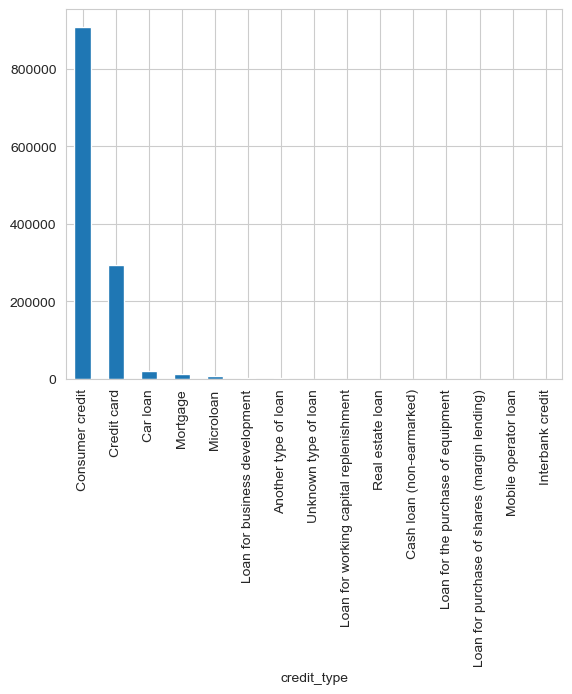

In [18]:
accounts_data_train['credit_type'].value_counts().plot.bar()

### Observation:-
- Most of the loans are of type consumer credit or credit card.

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


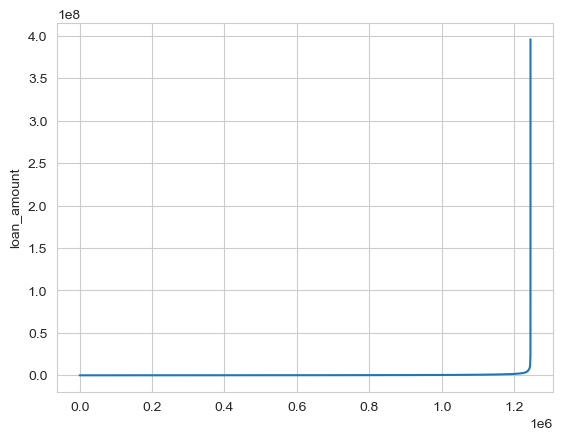

In [19]:
sns.lineplot(sorted(accounts_data_train['loan_amount']))
plt.ylabel('loan_amount')
plt.show()

In [20]:
accounts_data_train['loan_amount'].quantile(0.9)

765000.0

### Observation
- 90% of the loan amounts are less than 7,65,000 only.

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


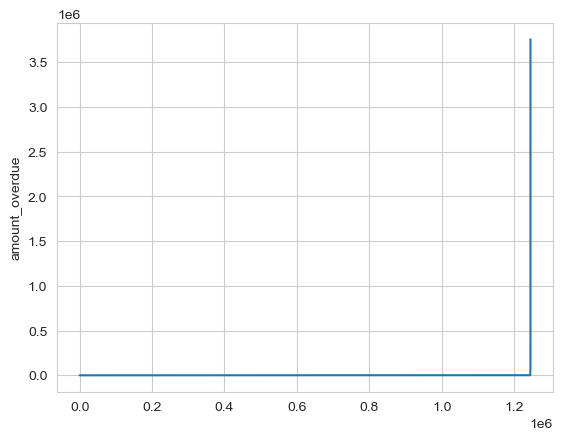

In [21]:
sns.lineplot(sorted(accounts_data_train['amount_overdue']))
plt.ylabel('amount_overdue')
plt.show()

In [22]:
accounts_data_train['amount_overdue'].quantile(0.997)

0.0

### Observation:-
- 99.7% of the amount overdues are equal to 0 only.

<Axes: xlabel='enquiry_type'>

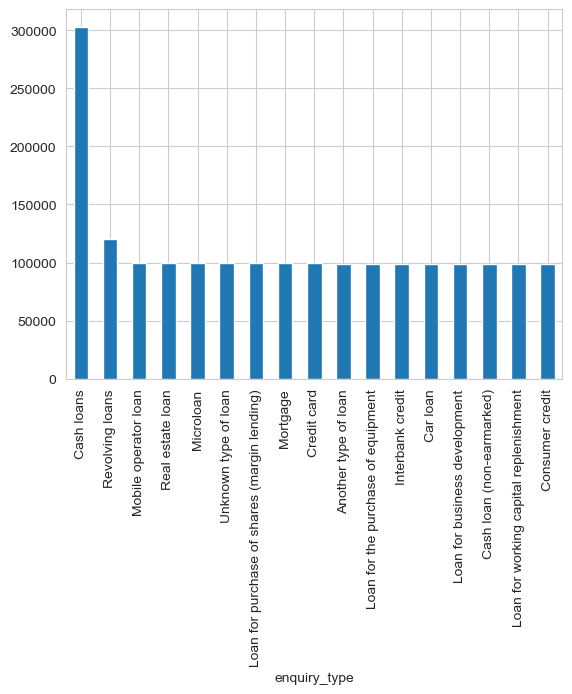

In [23]:
enquiry_data_train['enquiry_type'].value_counts().plot.bar()

D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
D:\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


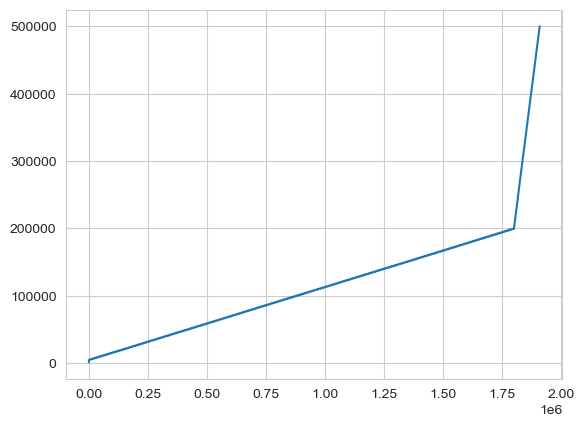

In [24]:
sns.lineplot(sorted(enquiry_data_train['enquiry_amt']))
plt.show()

<Axes: xlabel='NAME_CONTRACT_TYPE,TARGET'>

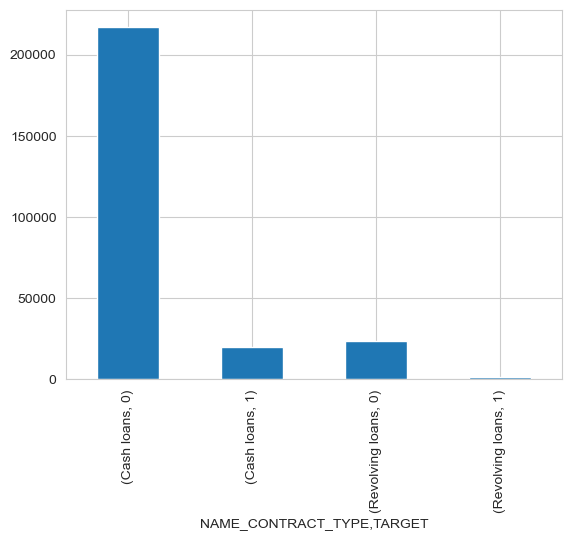

In [25]:
train_flag.groupby('NAME_CONTRACT_TYPE')['TARGET'].value_counts().plot.bar()

TARGET
0    240326
1     21057
Name: count, dtype: int64
8.06% of the points are bad


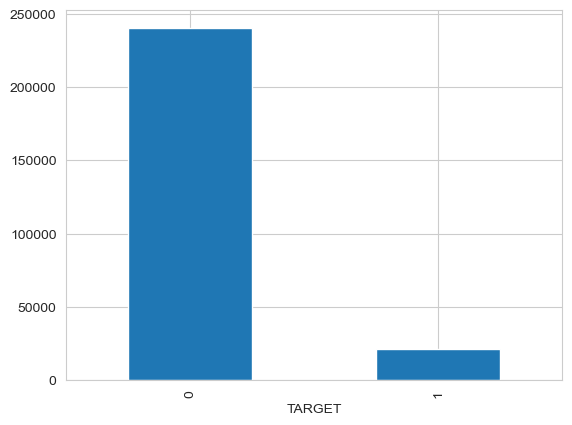

In [26]:
tf_vc = train_flag['TARGET'].value_counts()
print(tf_vc)
tf_vc.plot.bar()
print(f'{round(tf_vc[1]*100/(tf_vc[0]+tf_vc[1]),2)}% of the points are bad')

### Observation:-
- This is an imbanced dataset.

## 5 Dataset Preparation

In [27]:
# we use the following to convert the payment_hist_string to total number of days
def n_days(row):
    string = row['payment_hist_string']
    n = len(string)
    if (n/3-int(n/3))>0:
        print(n)
    chunks = int(n/3)
    n_days = 0
    for i in range(chunks):
        n_days += int(string[3*i:3*i+3])
    return n_days

In [28]:
accounts_data_train['n_days'] = accounts_data_train.apply(n_days, axis=1)

# we add the following field to check if an applicant has outstanding loans because it would be helpful
accounts_data_train.loc[accounts_data_train['closed_date'].isnull(),'n_loans'] = 1
accounts_data_train.loc[~accounts_data_train['closed_date'].isnull(),'n_loans'] = 0

In [29]:
dataset_train = accounts_data_train.groupby('uid')[['loan_amount','amount_overdue','n_days','n_loans']].sum()
dataset_train = pd.concat([dataset_train, enquiry_data_train.groupby('uid')['enquiry_amt'].sum()],axis=1)

In [30]:
df = accounts_data_train.groupby('uid')['credit_type'].value_counts()
dataset_train['Consumer credit 1'] = 0
dataset_train['Credit card 1'] = 0
dataset_train['Car loan 1'] = 0
dataset_train['Mortgage 1'] = 0
dataset_train['Microloan 1'] = 0
dataset_train['Loan for business development 1'] = 0
dataset_train['Another type of loan 1'] = 0
dataset_train['Unknown type of loan 1'] = 0
dataset_train['Loan for working capital replenishment 1'] = 0
dataset_train['Real estate loan 1'] = 0
dataset_train['Cash loan (non-earmarked) 1'] = 0
dataset_train['Loan for the purchase of equipment 1'] = 0
dataset_train['Loan for purchase of shares (margin lending) 1'] = 0 
dataset_train['Interbank credit 1'] = 0 
dataset_train['Mobile operator loan 1'] = 0 

count = []
for elem in df:
    count.append(elem)
lst = []
for index, count in zip(df.index, count):
    lst.append([index[0], index[1], count])
for elem in lst:
    dataset_train.loc[elem[0],f'{elem[1]} 1'] = elem[2]

In [31]:
df = enquiry_data_train.groupby('uid')['enquiry_type'].value_counts()
dataset_train['Cash loans 2'] = 0
dataset_train['Revolving loans 2'] = 0
dataset_train['Mobile operator loan 2'] = 0
dataset_train['Real estate loan 2'] = 0
dataset_train['Microloan 2'] = 0
dataset_train['Unknown type of loan 2'] = 0
dataset_train['Loan for purchase of shares (margin lending) 2'] = 0
dataset_train['Mortgage 2'] = 0
dataset_train['Credit card 2'] = 0
dataset_train['Another type of loan 2'] = 0
dataset_train['Loan for the purchase of equipment 2'] = 0
dataset_train['Interbank credit 2'] = 0
dataset_train['Car loan 2'] = 0
dataset_train['Loan for business development 2'] = 0
dataset_train['Cash loan (non-earmarked) 2'] = 0
dataset_train['Loan for working capital replenishment 2'] = 0
dataset_train['Consumer credit 2'] = 0

count = []
for elem in df:
    count.append(elem)
lst = []
for index, count in zip(df.index, count):
    lst.append([index[0], index[1], count])
for elem in lst:
    dataset_train.loc[elem[0],f'{elem[1]} 2'] = elem[2]

In [32]:
dataset_train = pd.concat([dataset_train, train_flag[['uid','TARGET']].set_index('uid')], axis=1)

In [33]:
bad = []
total = []
for column in dataset_train.columns[:-1]:
    bad.append(dataset_train[(dataset_train[column]>0)&(dataset_train['TARGET']==1)].shape[0])
    total.append(dataset_train[dataset_train[column]>0].shape[0])
df = pd.DataFrame({'Column':dataset_train.columns[:-1],'Bad':bad,'Total':total})
df['Fraction'] = df['Bad']/df['Total']
df[(df['Fraction']>0.09)|(df['Fraction']<0.07)].sort_values('Fraction')

,Column,Bad,Total,Fraction
14,Real estate loan 1,0,17,0.000000
17,Loan for purchase of shares (margin lending) 1,0,4,0.000000
18,Interbank credit 1,0,1,0.000000
19,Mobile operator loan 1,0,1,0.000000
8,Mortgage 1,629,12098,0.051992
7,Car loan 1,963,16650,0.057838
10,Loan for business development 1,71,1185,0.059916
12,Unknown type of loan 1,22,336,0.065476
15,Cash loan (non-earmarked) 1,1,15,0.066667
13,Loan for working capital replenishment 1,40,279,0.143369


### Observations
- It is 2.5 times more probable that the loan could be default if the applicant had taken the microloan or loan for the purchase of the equipment.
- It is 2 times more probable that the loan could be default if the applicant had amount_overdue.
- It is 1.5 times more probable that the loan could be default if the applicant had taken loan for working capital replenishment.
- It is relatively less probable that the loan could be default if the applicant had taken mortgage, car loan or loan for business development.
- It appears that the number of days post due date does not have much effect on the outcome.
- It appears that the number of outstanding loans does not have much effect on the outcome. But at higher thresholds, we can see that the probability is high.

In [34]:
dataset_train.loc[dataset_train['loan_amount'].isnull(),['loan_amount','amount_overdue','n_days','n_loans']] = 0

In [35]:
dataset_train.head()

,loan_amount,amount_overdue,n_days,n_loans,enquiry_amt,Consumer credit 1,Credit card 1,Car loan 1,Mortgage 1,Microloan 1,...,Credit card 2,Another type of loan 2,Loan for the purchase of equipment 2,Interbank credit 2,Car loan 2,Loan for business development 2,Cash loan (non-earmarked) 2,Loan for working capital replenishment 2,Consumer credit 2,TARGET
uid,,,,,,,,,,,,,,,,,,,,,
AAA09044550,277245.000,0.0,68.0,0.0,2659000,2,0,0,0,0,...,1,3,1,2,3,0,1,0,1,0
AAA10545297,80996.445,0.0,0.0,1.0,1317000,0,1,0,0,0,...,2,1,0,1,0,0,2,0,2,0
AAA14112888,43771.500,0.0,0.0,0.0,1465000,1,0,0,0,0,...,0,1,2,1,0,0,1,2,2,0
AAA20326915,591597.000,0.0,14477.0,3.0,66000,5,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAA31604840,1591960.500,0.0,0.0,3.0,1826000,4,1,0,0,0,...,0,1,2,1,0,3,1,0,2,0


In [36]:
n = len(dataset_train)
X_train = dataset_train.iloc[:int(0.7*n),:-1].values
X_cv = dataset_train.iloc[int(0.7*n):int(0.85*n),:-1].values
X_test = dataset_train.iloc[int(0.85*n):,:-1].values
y_train = dataset_train.iloc[:int(0.7*n),-1].values
y_cv = dataset_train.iloc[int(0.7*n):int(0.85*n),-1].values
y_test = dataset_train.iloc[int(0.85*n):,-1].values

In [37]:
X_train.shape

(182968, 37)

In [38]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_cv)

# 6 Building Machine Learning Models

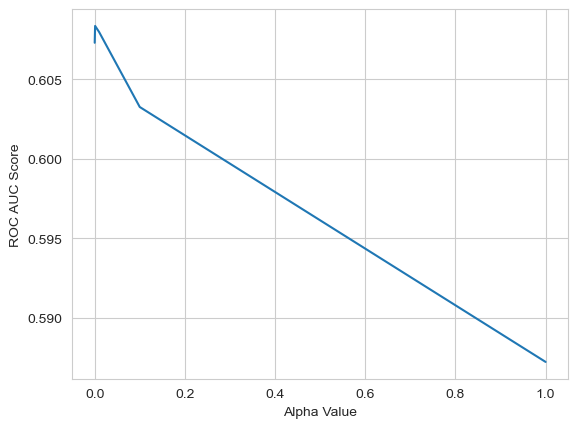

In [39]:
alpha = [10**i for i in range(-4,1)]
cv_roc_auc_score = []

for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight = 'balanced', loss = 'log_loss')
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_roc_auc_score.append(roc_auc_score(y_cv, y_pred[:,1]))

plt.plot(alpha, cv_roc_auc_score)
plt.xlabel('Alpha Value')
plt.ylabel('ROC AUC Score')
plt.show()

In [40]:
best_alpha = alpha[np.argmax(cv_roc_auc_score)]
clf_lr = SGDClassifier(loss = 'log_loss', alpha = best_alpha, class_weight = 'balanced')
clf_lr.fit(X_train, y_train)
sig_clf_lr = CalibratedClassifierCV(clf_lr)
sig_clf_lr.fit(X_train, y_train)
roc_auc_score_lr = roc_auc_score(y_cv, sig_clf_lr.predict_proba(X_cv)[:,1])

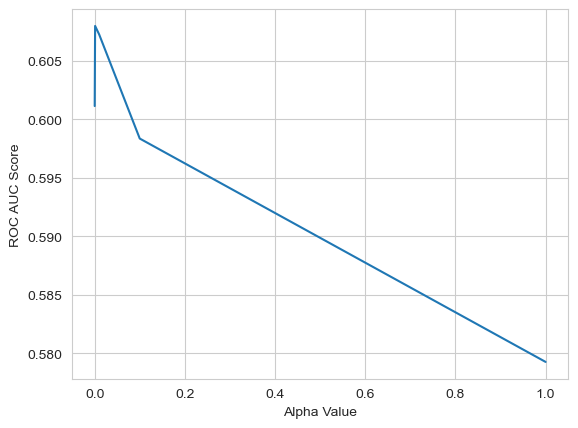

In [41]:
alpha = [10**i for i in range(-4,1)]
cv_roc_auc_score = []

for i in alpha:
    clf = SGDClassifier(alpha = i, class_weight = 'balanced', loss = 'hinge')
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_roc_auc_score.append(roc_auc_score(y_cv, y_pred[:,1]))

plt.plot(alpha, cv_roc_auc_score)
plt.xlabel('Alpha Value')
plt.ylabel('ROC AUC Score')
plt.show()

In [42]:
best_alpha = alpha[np.argmax(cv_roc_auc_score)]
clf_svc = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', loss = 'hinge')
clf_svc.fit(X_train, y_train)
sig_clf_svc = CalibratedClassifierCV(clf_svc)
sig_clf_svc.fit(X_train, y_train)
roc_auc_score_svc = roc_auc_score(y_cv, sig_clf_svc.predict_proba(X_cv)[:,1])

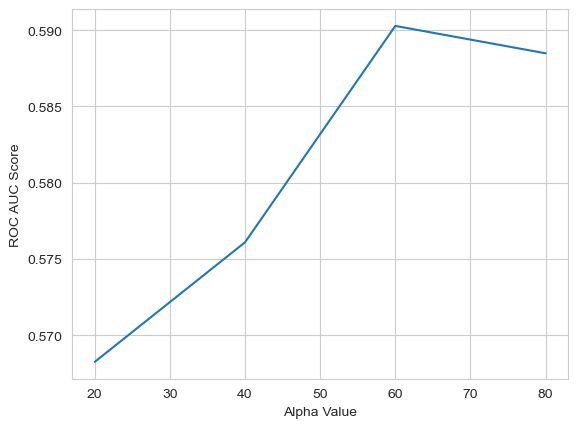

In [64]:
alpha = [20, 40, 60, 80]
cv_roc_auc_score = []
for i in alpha:
    clf = RandomForestClassifier(max_depth = i, class_weight = 'balanced')
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(X_train, y_train)
    y_pred = sig_clf.predict_proba(X_cv)
    cv_roc_auc_score.append(roc_auc_score(y_cv, y_pred[:,1]))

plt.plot(alpha, cv_roc_auc_score)
plt.xlabel('Alpha Value')
plt.ylabel('ROC AUC Score')
plt.show()

In [43]:
best_alpha = alpha[np.argmax(cv_roc_auc_score)]
clf_rf = RandomForestClassifier(max_depth = best_alpha,class_weight = 'balanced')
clf_rf.fit(X_train, y_train)
sig_clf_rf = CalibratedClassifierCV(clf_rf)
sig_clf_rf.fit(X_train, y_train)
roc_auc_score_rf = roc_auc_score(y_cv,sig_clf_rf.predict_proba(X_cv)[:,1]),

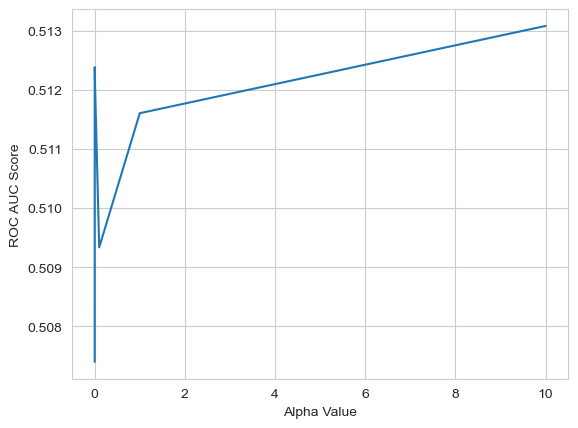

In [51]:
alpha = [0.0001,0.001,0.01,0.1,1,10]
cv_roc_auc_score = []
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers = [sig_clf_rf, sig_clf_lr, sig_clf_svc],meta_classifier = lr, use_probas = True)
    sclf.fit(X_train, y_train)
    y_pred = sclf.predict_proba(X_cv)
    cv_roc_auc_score.append(roc_auc_score(y_cv, y_pred[:,1]))

plt.plot(alpha, cv_roc_auc_score)
plt.xlabel('Alpha Value')
plt.ylabel('ROC AUC Score')
plt.show()

In [46]:
best_alpha = alpha[np.argmax(cv_roc_auc_score)]
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers = [sig_clf_rf, sig_clf_lr, sig_clf_svc], meta_classifier = lr, use_probas = True)
sclf.fit(X_train, y_train)
roc_auc_score_sclf = roc_auc_score(y_cv,sclf.predict_proba(X_cv)[:,1])

In [ ]:
vclf = VotingClassifier(estimators=[('lr', sig_clf_lr), ('svc', sig_clf_svc), ('rf', sig_clf_rf)], voting='soft')
vclf.fit(X_train, y_train)
y_pred = vclf.predict(X_cv)
roc_auc_score_vclf = roc_auc_score(y_cv,vclf.predict_proba(X_cv)[:,-1])

In [ ]:
xgbclf = XGBClassifier()
xgbclf.fit(X_train, y_train)
y_pred = xgbclf.predict(X_cv)
roc_auc_score_xgbclf = roc_auc_score(y_cv,xgbclf.predict_proba(X_cv)[:,1])

In [ ]:
print(roc_auc_score_lr, roc_auc_score_svc, roc_auc_score_rf, roc_auc_score_sclf, roc_auc_score_vclf, roc_auc_score_xgbclf)

In [ ]:
accounts_data_test = pd.read_json('new_test/accounts_data_test.json').sort_values('open_date')
enquiry_data_test = pd.read_json('new_test/enquiry_data_test.json').sort_values('enquiry_date')
test_flag = pd.read_csv('new_test/test_flag.csv')
accounts_data_test['open_date'] = pd.to_datetime(accounts_data_test['open_date'])
accounts_data_test['closed_date'] = pd.to_datetime(accounts_data_test['closed_date'])
enquiry_data_test['enquiry_date'] = pd.to_datetime(enquiry_data_test['enquiry_date'])

In [ ]:
accounts_data_test['n_days'] = accounts_data_test.apply(n_days, axis=1)

# we add the following field to check if an applicant has outstanding loans because it would be helpful
accounts_data_test.loc[accounts_data_test['closed_date'].isnull(),'n_loans'] = 1
accounts_data_test.loc[~accounts_data_test['closed_date'].isnull(),'n_loans'] = 0

In [ ]:
dataset_test = accounts_data_test.groupby('uid')[['loan_amount','amount_overdue','n_days','n_loans']].sum()
dataset_test = pd.concat([dataset_test, enquiry_data_test.groupby('uid')['enquiry_amt'].sum()],axis=1)

In [ ]:
df = accounts_data_test.groupby('uid')['credit_type'].value_counts()
dataset_test['Consumer credit 1'] = 0
dataset_test['Credit card 1'] = 0
dataset_test['Car loan 1'] = 0
dataset_test['Mortgage 1'] = 0
dataset_test['Microloan 1'] = 0
dataset_test['Loan for business development 1'] = 0
dataset_test['Another type of loan 1'] = 0
dataset_test['Unknown type of loan 1'] = 0
dataset_test['Loan for working capital replenishment 1'] = 0
dataset_test['Real estate loan 1'] = 0
dataset_test['Cash loan (non-earmarked) 1'] = 0
dataset_test['Loan for the purchase of equipment 1'] = 0
dataset_test['Loan for purchase of shares (margin lending) 1'] = 0 
dataset_test['Interbank credit 1'] = 0 
dataset_test['Mobile operator loan 1'] = 0 

count = []
for elem in df:
    count.append(elem)
lst = []
for index, count in zip(df.index, count):
    lst.append([index[0], index[1], count])
for elem in lst:
    dataset_test.loc[elem[0],f'{elem[1]} 1'] = elem[2]

In [ ]:
df = enquiry_data_test.groupby('uid')['enquiry_type'].value_counts()
dataset_test['Cash loans 2'] = 0
dataset_test['Revolving loans 2'] = 0
dataset_test['Mobile operator loan 2'] = 0
dataset_test['Real estate loan 2'] = 0
dataset_test['Microloan 2'] = 0
dataset_test['Unknown type of loan 2'] = 0
dataset_test['Loan for purchase of shares (margin lending) 2'] = 0
dataset_test['Mortgage 2'] = 0
dataset_test['Credit card 2'] = 0
dataset_test['Another type of loan 2'] = 0
dataset_test['Loan for the purchase of equipment 2'] = 0
dataset_test['Interbank credit 2'] = 0
dataset_test['Car loan 2'] = 0
dataset_test['Loan for business development 2'] = 0
dataset_test['Cash loan (non-earmarked) 2'] = 0
dataset_test['Loan for working capital replenishment 2'] = 0
dataset_test['Consumer credit 2'] = 0

count = []
for elem in df:
    count.append(elem)
lst = []
for index, count in zip(df.index, count):
    lst.append([index[0], index[1], count])
for elem in lst:
    dataset_test.loc[elem[0],f'{elem[1]} 2'] = elem[2]

In [ ]:
dataset_test = pd.concat([dataset_test, test_flag[['uid']].set_index('uid')], axis=1)

In [ ]:
dataset_test

In [ ]:
dataset_test.loc[dataset_test['loan_amount'].isnull(),['loan_amount','amount_overdue','n_days','n_loans']] = 0

In [ ]:
X_test = scaler.transform(dataset_test.values)

In [ ]:
y_pred = vclf.predict_proba(X_test)

In [103]:
df = pd.DataFrame({'uid':dataset_test.index, 'pred':y_pred[:,1]})
df.to_csv('final_submission/final_submission_Krishna_Sumanth_Mannala.csv', index=False)